# Training a ML model using CICIoT2023

This notebook shows how a LogisticRegression model can be trained using the CICIoT2023 csv files.

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


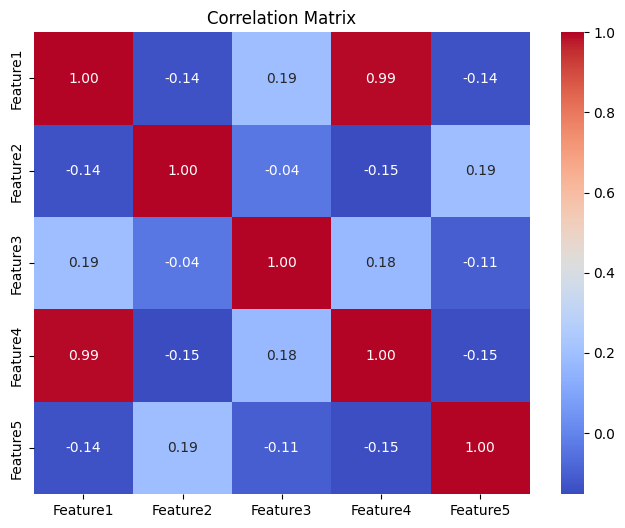

Features dropped due to high correlation: ['Feature2', 'Feature3', 'Feature4', 'Feature5']


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame
np.random.seed(42)
data = {
    'Feature1': np.random.normal(0, 1, 100),
    'Feature2': np.random.normal(0, 1, 100),
    'Feature3': np.random.normal(0, 1, 100),
    'Feature4': np.random.normal(0, 1, 100) * 2,
    'Feature5': np.random.normal(0, 1, 100) + 5,
}
df = pd.DataFrame(data)

# Add some correlation
df['Feature4'] = df['Feature1'] * 0.9 + np.random.normal(0, 0.1, 100)

# Step 1: Correlation Analysis
corr_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Drop highly correlated features (e.g., correlation > 0.9)
threshold = 0.9
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > threshold) and column != corr_matrix.columns[0]]
df_reduced = df.drop(columns=to_drop)
print(f"Features dropped due to high correlation: {to_drop}")

# Step 2: Dimension Reduction Using PCA
# Standardize the data (optional but recommended for PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_reduced)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
df_pca = pca.fit_transform(df_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by components: {explained_variance}")

# Visualize PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.7, c='blue')
plt.title('PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [31]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

### Importing Dataset

In [ ]:
DATASET_DIRECTORY = './data/'
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()


['0.001percent_2classes.csv', '0.001percent_34classes.csv', '0.001percent_8classes.csv', '0.005percent_2classes.csv', '0.005percent_34classes.csv', '0.005percent_8classes.csv', '0.01percent_2classes.csv', '0.01percent_34classes.csv', '0.01percent_8classes.csv']


In [39]:
print('Loading datasets...')
df = pd.read_csv(DATASET_DIRECTORY + '0.001percent_34classes.csv')
labels = df['label'].unique()
# count on each label
print('Counting labels...')
label_count = df['label'].value_counts()
print(label_count)    

Loading datasets...
Counting labels...
label
DDoS-ICMP_Flood            7201
DDoS-UDP_Flood             5412
DDoS-TCP_Flood             4490
DDoS-PSHACK_Flood          4093
DDoS-SYN_Flood             4059
DDoS-RSTFINFlood           4051
DDoS-SynonymousIP_Flood    3600
DoS-UDP_Flood              3325
DoS-TCP_Flood              2673
DoS-SYN_Flood              2025
BenignTraffic              1093
Mirai-greeth_flood          994
Mirai-udpplain              889
Mirai-greip_flood           767
DDoS-ICMP_Fragmentation     413
MITM-ArpSpoofing            345
DDoS-UDP_Fragmentation      278
DDoS-ACK_Fragmentation      274
DNS_Spoofing                200
Recon-HostDiscovery         169
Recon-OSScan                102
Recon-PortScan               31
DoS-HTTP_Flood               31
Name: count, dtype: int64


In [3]:
DATASET_PREFIX = '0.001percent'

training_sets = [k for k in df_sets if k.startswith(DATASET_PREFIX)]
test_sets = [k for k in df_sets if k.startswith(DATASET_PREFIX)]

print(training_sets)
print(test_sets)

# the dataset for total data
#training_sets = df_sets[:int(len(df_sets)*.8)]
#test_sets = df_sets[int(len(df_sets)*.8):]

['0.001percent_2classes.csv', '0.001percent_34classes.csv', '0.001percent_8classes.csv']
['0.001percent_2classes.csv', '0.001percent_34classes.csv', '0.001percent_8classes.csv']


In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

In [5]:
def rectify_cols(columns):
    
    result = [col.lower() for col in X_columns]
    # replace spaces with underscores
    result = [col.replace(' ', '_') for col in result]
    # result.remove('magnitue')
    return result

X_columns = rectify_cols(X_columns)
print(X_columns)

['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius', 'covariance', 'variance', 'weight']


In [ ]:
# Map IANA Protocol numbers to strings (leave user option to 1-hot or numerically encode)
iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}

def iana_convert(df):
    df["Protocol Type"] = df["Protocol Type"].apply(lambda num : iana_map[ str(int(num)) ])
    return df
# change label to integer
def preprocess_data(data):
    data['label'] = data['label'].apply(lambda x: 1 if x == 'Botnet' else 0)
    return data

In [29]:
import pandas as pd
import numpy as np

# Sample DataFrame
data = {
    "label": ["A", "A", "A", "A", "A", "B", "A", "C", "A", "A"]
}
df = pd.DataFrame(data)

# Calculate proportions
proportions = df['label'].value_counts(normalize=True).sort_index()

# proportions = [0.89,0.1,0.01]

# Power transformation for controlled distortion
power = 0.5  # Adjustable parameter: 0 < power <= 1
transformed_proportions = proportions ** power

# Normalize to ensure sum = 1
distorted_proportions = transformed_proportions / transformed_proportions.sum()

# Convert to a dictionary
# distorted_map = distorted_proportions.to_dict()

distorted_map = dict(zip(proportions.index, distorted_proportions))

# Display result
print("Original proportions:", proportions.to_dict())
print("Distorted proportions (map):", distorted_map)
print(distorted_map.get('A'))

Original proportions: {'A': 0.8, 'B': 0.1, 'C': 0.1}
Distorted proportions (map): {'A': 0.585786437626905, 'B': 0.20710678118654752, 'C': 0.20710678118654752}
0.585786437626905


### Scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
DATASET_SUFFIX = '34classes.csv'
train_set = [k for k in training_sets if k.endswith(DATASET_SUFFIX)]
test_set = [k for k in test_sets if k.endswith(DATASET_SUFFIX)]
print(train_set)
print(test_set) 

for train_set in tqdm(training_sets):
    scaler.fit(pd.read_csv(DATASET_DIRECTORY + train_set)[X_columns]) 

['0.001percent_34classes.csv']
['0.001percent_34classes.csv']


  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: could not convert string to float: 'UDP'

### Classification: 34 (33+1) classes

In [ ]:
ML_models = [
        LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "LogisticRegression",
]

for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

['0.001percent_34classes.csv']
['0.001percent_34classes.csv']


  0%|          | 0/3 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data0.001percent_2classes.csv'

In [8]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (34 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

# Classification: 8 (7+1) classes

In [10]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


ML_models = [
        LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_7classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

In [12]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (8 classes) #####")
    print('accuracy_score = ', accuracy_score(y_pred, y_test))
    print('recall_score = ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score = ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score = ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

# Classification: 2 (1+1) Classes

In [14]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'

dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


ML_models = [
        LogisticRegression(n_jobs=-1),
]

ML_neams = [
        "LogisticRegression",
]


for train_set in tqdm(training_sets):
    d = pd.read_csv(DATASET_DIRECTORY + train_set)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    
    for model in (ML_models):
        model.fit(d[X_columns], d[y_column])
    del d

In [16]:
y_test = []
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    
    y_test += list(d_test[y_column].values)
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        preds[i] = preds[i] + y_pred
        

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
for k,v in preds.items():
    y_pred = v
    print(f"##### {ML_neams[k]} (2 classes) #####")
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))
    print()
    print()
    print()

In [3]:
# fitler cols
filter_vars = ["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", 
               "syn_count", "rst_count", "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", 
               "min", "iat", "magnitude", "radius", "variance"]
# Drop unbalanced features and unclear features
unbalanced_feat = ["drate", "smtp", "irc", "telnet", "ssh", "dhcp", "arp", "ipv", "llc", "dns", "cwr_flag_number", 
                   "ece_flag_number", "rst_flag_number", "syn_flag_number"]
unclear_feat = ["protocol_type", "tot_size"]
feat2drop = unbalanced_feat + unclear_feat

# compare cols
# filter2_col = tr_cols.remove(feat2drop)
# Create a new list excluding elements from the remove_array
filtered_list = [item for item in filter_vars if item not in feat2drop]
print(filtered_list)

import numpy as np

# Define two arrays of strings
array1 = np.array(filter_vars)
array2 = np.array(filtered_list)

# Find elements in array1 but not in array2
only_in_array1 = np.setdiff1d(array1, array2)

# Find elements in array2 but not in array1
only_in_array2 = np.setdiff1d(array2, array1)

# Display results
print("Elements in array1 but not in array2:", only_in_array1)
print("Elements in array2 but not in array1:", only_in_array2)

['duration', 'srate', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'rst_count', 'header_length', 'https', 'flow_duration', 'avg', 'max', 'tot_sum', 'min', 'iat', 'magnitude', 'radius', 'variance']
Elements in array1 but not in array2: ['drate' 'ssh' 'syn_flag_number']
Elements in array2 but not in array1: []
